## Reference:
https://keon.io/deep-q-learning/
http://mckinziebrandon.me/TensorflowNotebooks/2016/12/21/openai.html
https://github.com/yenchenlin/DeepLearningFlappyBird

In [ ]:
!pip install gym
!conda install -y JSAnimation

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dot
from keras.models import load_model, model_from_json
from keras.optimizers import Adam

import gym

from collections import deque

import time

%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

Using TensorFlow backend.


In [10]:
def create_model(n_states, n_actions):
    
    state = Input(shape=(n_states,))
    x1 = Dense(4, activation='relu')(state)
    x2 = Dense(4, activation='relu')(x1)
    out = Dense(n_actions)(x2)
    actions = Input(shape=(n_actions,))
    out2 = Dot(axes=-1)([out, actions])

    model = Model(inputs=[state, actions], outputs=out2)
    model.compile(loss='mse', optimizer='rmsprop')
    
    model2 = Model(inputs=state, outputs=out)

    return model, model2

In [9]:
def train_data(minibatch, model):
    s_j_batch = np.array([d[0] for d in minibatch])
    a_batch = np.array([d[1] for d in minibatch])
    r_batch = np.array([d[2] for d in minibatch])
    s_j1_batch = np.array([d[3] for d in minibatch])
    terminal_batch = np.array([d[4] for d in minibatch])

    readout_j1_batch = model.predict(s_j1_batch, batch_size=BATCH)
    y_batch = r_batch + GAMMA * np.max(readout_j1_batch, axis=1)
    y_batch[terminal_batch] = r_batch[terminal_batch]
    
    return s_j_batch, a_batch, y_batch

In [11]:
env = gym.make('CartPole-v0')
STATES, ACTIONS = env.observation_space.shape[0], env.action_space.n
model, out = create_model(STATES, ACTIONS)
INITIAL_EPSILON = 1e-1
FINAL_EPSILON = 1e-4
DECAY = 0.9
GAMMA = 0.9 # decay rate of past observations
OBSERVE = 5000. # timesteps to observe before training
REPLAY_MEMORY = 5000 # number of previous transitions to remember
TIME_LIMIT = 100000
BATCH = 128
# open up a game state to communicate with emulator
state = env.reset()

# store the previous observations in replay memory
D = deque(maxlen=REPLAY_MEMORY)
loss = []

a_t = np.zeros(ACTIONS)
a_t[np.random.choice(ACTIONS)] = 1
s_t, r_0, terminal, _ = env.step(np.argmax(a_t))

# start training
epsilon = INITIAL_EPSILON

up_time = [0]
start = time.time()
for t in range(TIME_LIMIT):
    # choose an action
    readout_t = out.predict(s_t[None, :])
    a_t = np.zeros([ACTIONS])
    if np.random.random() <= epsilon:
        a_t[np.random.choice(ACTIONS)] = 1
    else:
        a_t[np.argmax(readout_t)] = 1

    # scale down epsilon
    if epsilon > FINAL_EPSILON and t > OBSERVE:
        epsilon *= DECAY

    # run the selected action and observe next state and reward
    # store the transition in D
    s_t1, r_t, terminal, _ = env.step(np.argmax(a_t))
    D.append((s_t, a_t, r_t, s_t1, terminal))
    
    if terminal:
        up_time.append(0)
        env.reset()
    else:
        up_time[-1] += r_t
    
    # only train if done observing
    if t > OBSERVE:
        # sample a minibatch to train on
        idx = np.random.choice(REPLAY_MEMORY, BATCH, replace=False)
        minibatch = [D[i] for i in idx]
        # get the batch variables
        s_t_batch, a_batch, y_batch = train_data(minibatch, out)
        # perform gradient step
        loss.append(model.train_on_batch([s_t_batch, a_batch], y_batch))

    # update the old state
    s_t = s_t1
        
    if t%(TIME_LIMIT/20)==0:
        print('Episode :', t, ', time taken: ', time.time() - start, 's, average up time: ',np.mean(up_time[-100:]))
        start = time.time()

[2017-10-18 16:31:55,532] Making new env: CartPole-v0


Episode : 0 , time taken:  0.06183505058288574 s, average up time:  1.0
Episode : 5000 , time taken:  1.6280219554901123 s, average up time:  20.67
Episode : 10000 , time taken:  11.734428882598877 s, average up time:  14.96
Episode : 15000 , time taken:  11.335469007492065 s, average up time:  13.52
Episode : 20000 , time taken:  11.325155973434448 s, average up time:  18.4
Episode : 25000 , time taken:  11.290104150772095 s, average up time:  12.11
Episode : 30000 , time taken:  11.34644103050232 s, average up time:  14.32
Episode : 35000 , time taken:  11.383343935012817 s, average up time:  20.06
Episode : 40000 , time taken:  11.315423965454102 s, average up time:  56.41
Episode : 45000 , time taken:  11.306735038757324 s, average up time:  96.59
Episode : 50000 , time taken:  11.365839958190918 s, average up time:  80.29
Episode : 55000 , time taken:  11.485472202301025 s, average up time:  124.32
Episode : 60000 , time taken:  12.377530097961426 s, average up time:  119.29
Episo

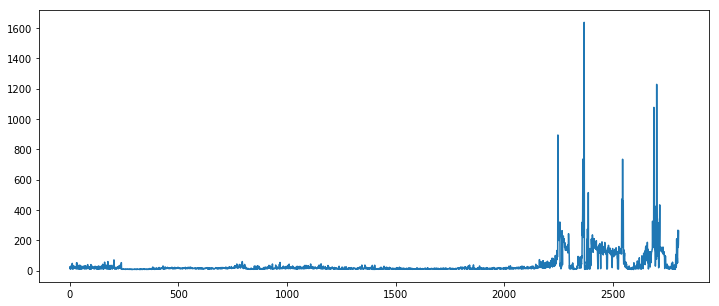

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(up_time)
plt.show()

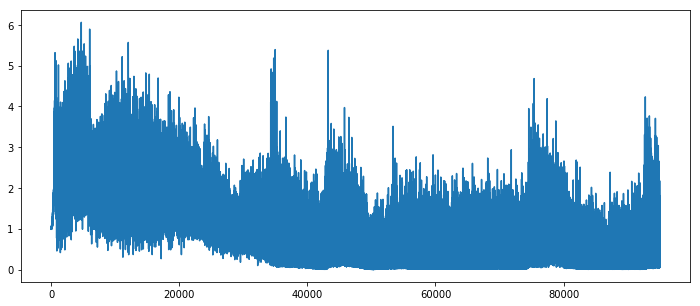

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(loss)
plt.show()

**Only run the following if you are running it locally and not in Docker**

In [6]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))

[2017-10-18 16:44:37,263] Making new env: CartPole-v0



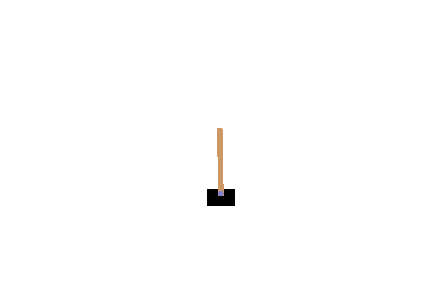
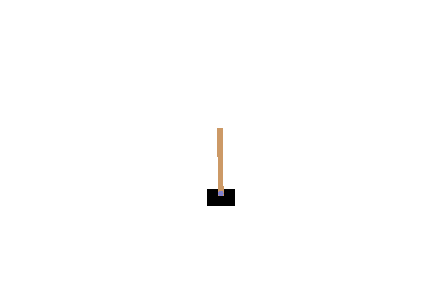
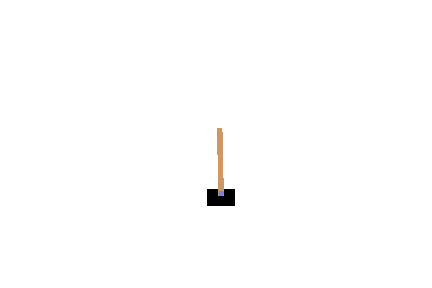
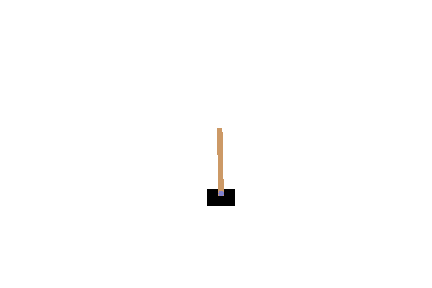
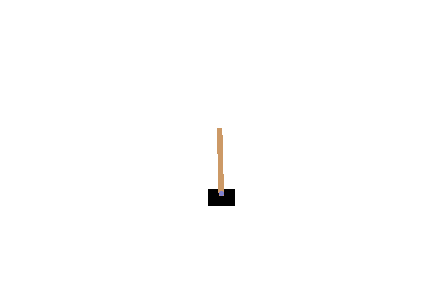
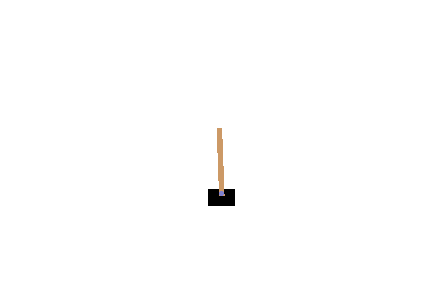
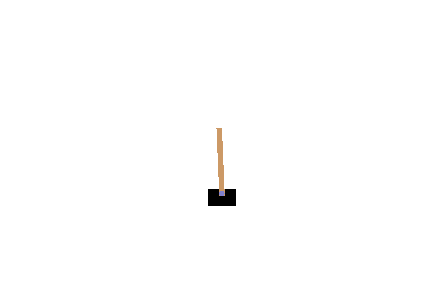
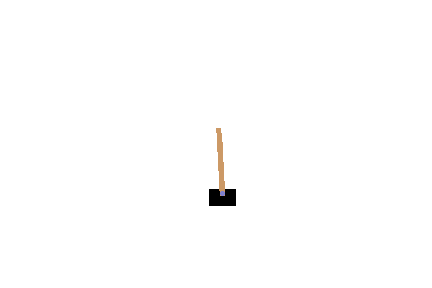
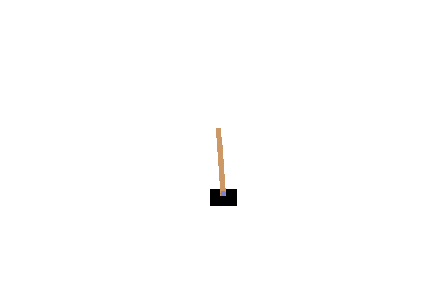
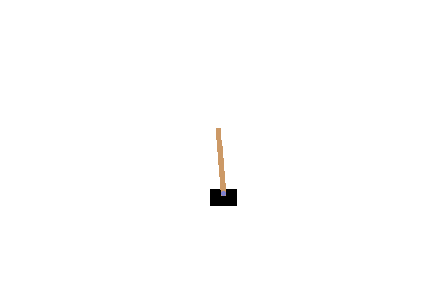
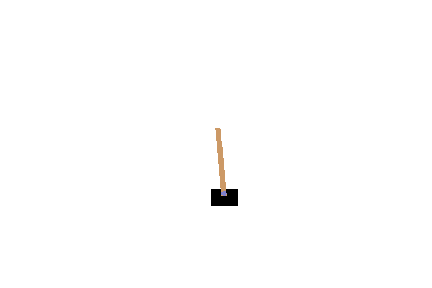
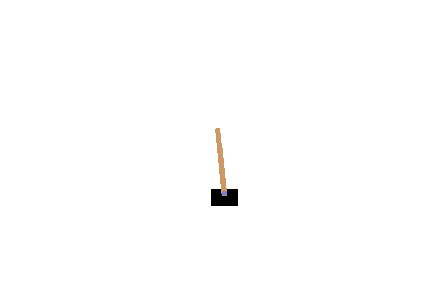
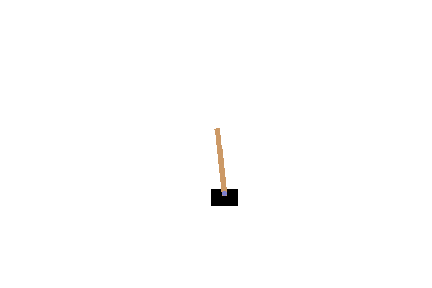
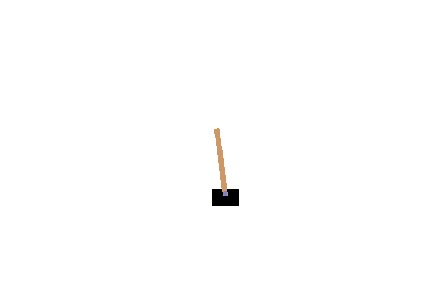
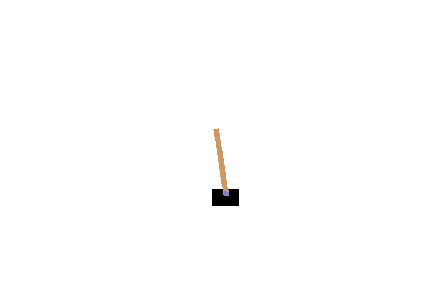
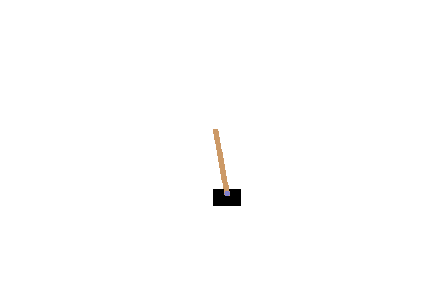

15


In [23]:
env = gym.make('CartPole-v0')

# Run a demo of the environment
observation = env.reset()
cum_reward = 0
frames = []
for t in range(5000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break
env.render(close=True)
display_frames_as_gif(frames)
print(t)


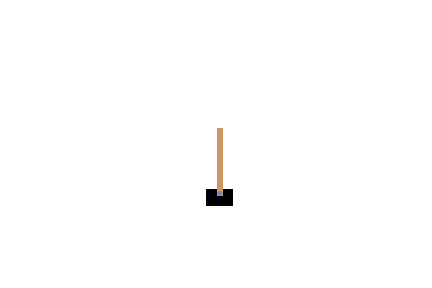
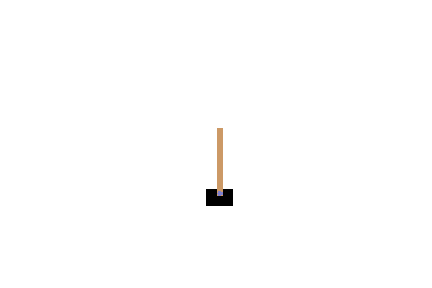
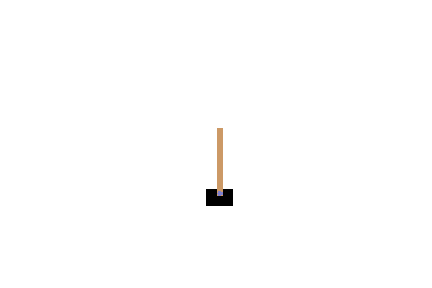
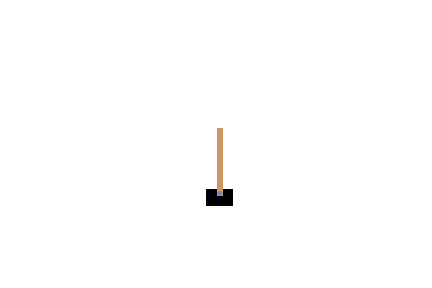
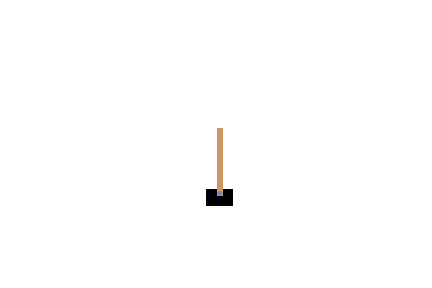
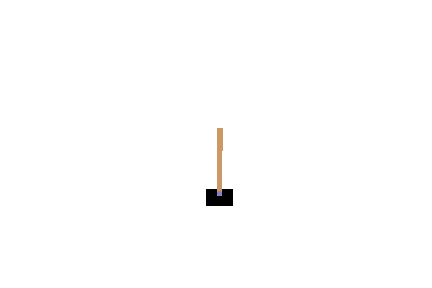
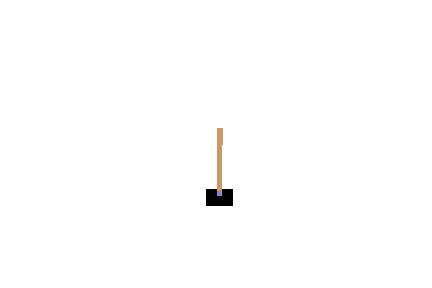
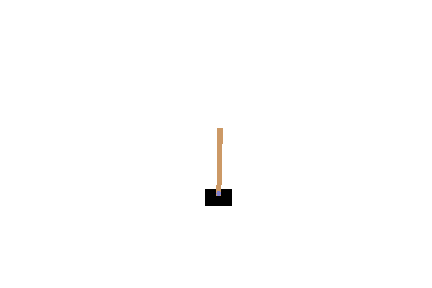
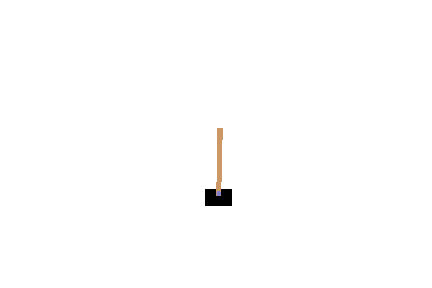
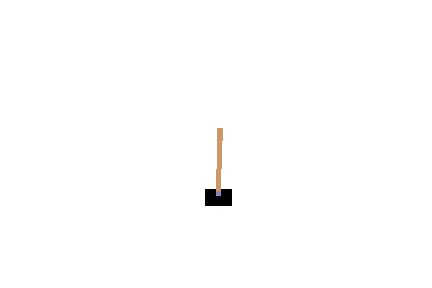
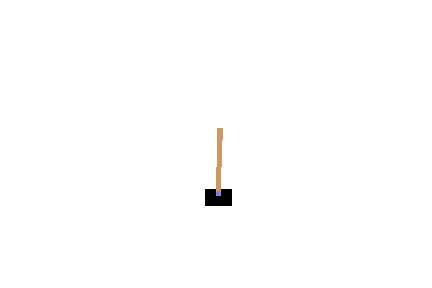
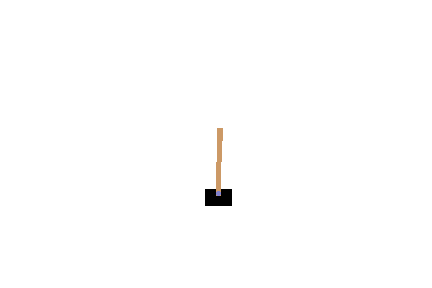
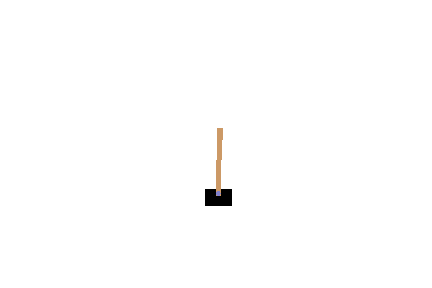
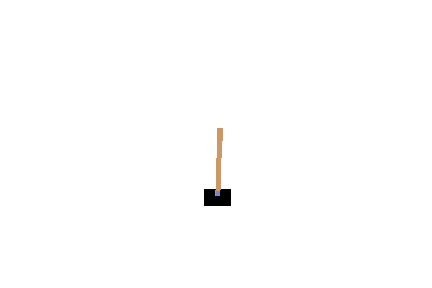
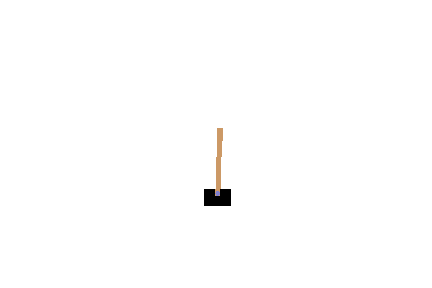
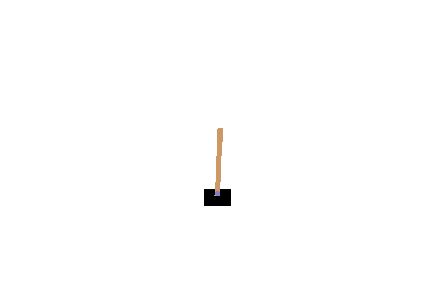
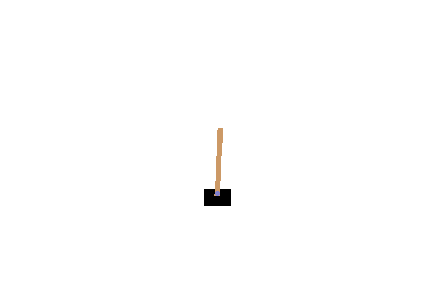
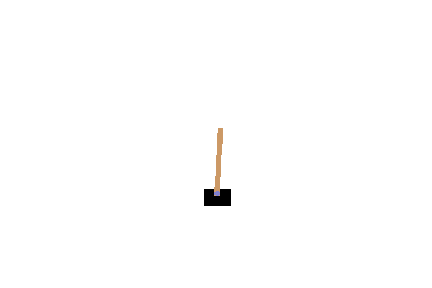
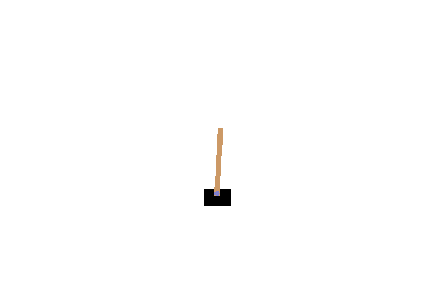
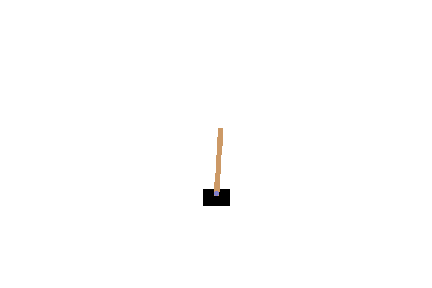
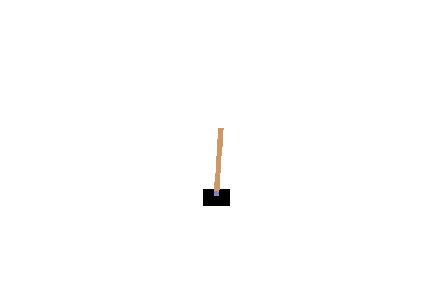
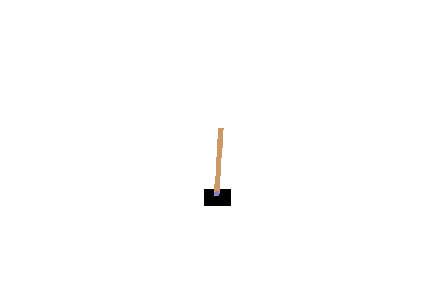
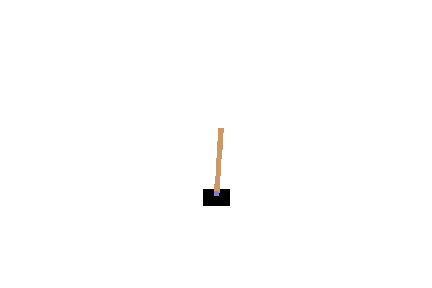
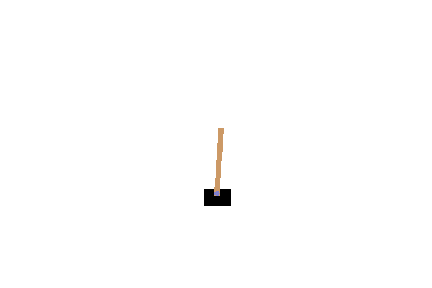
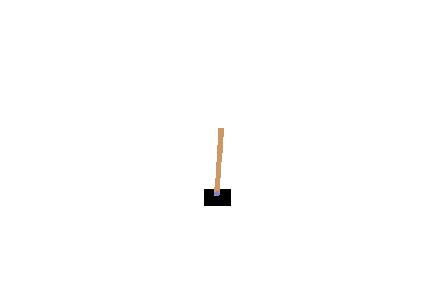
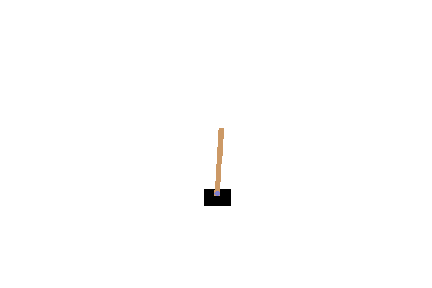
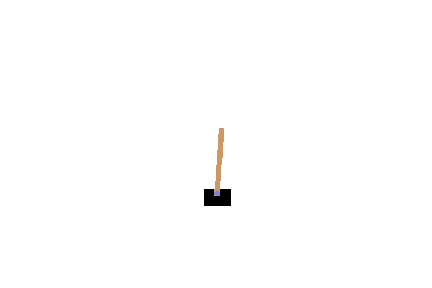
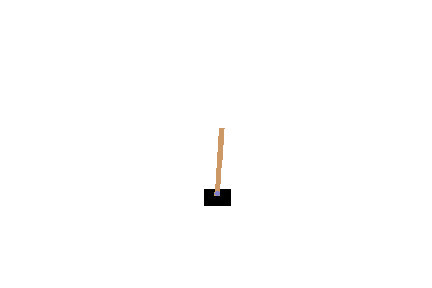
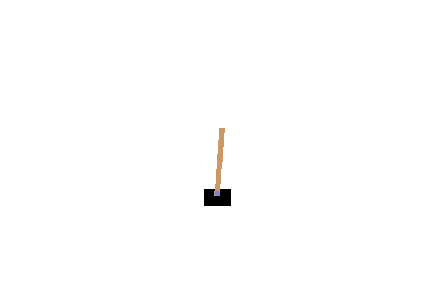
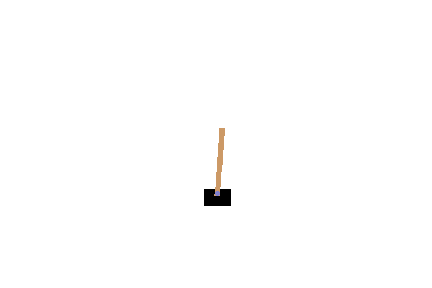
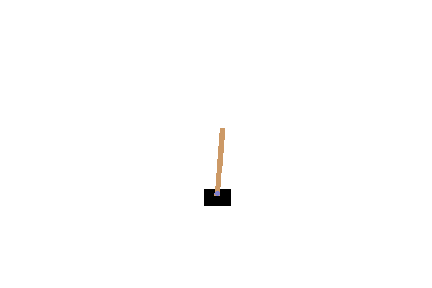
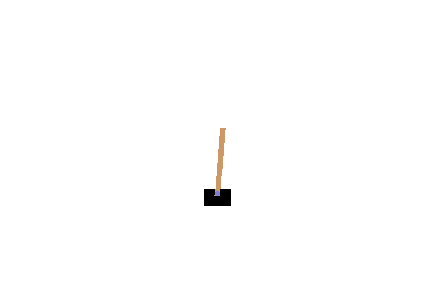
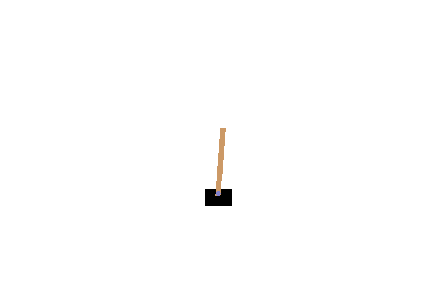
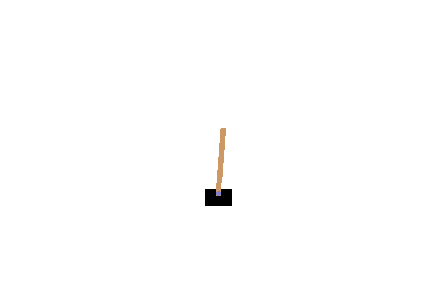
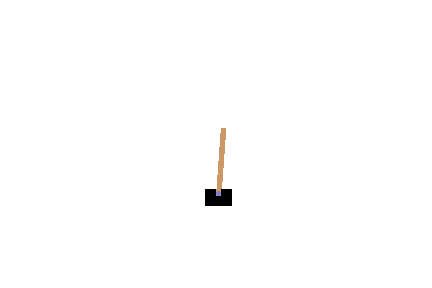
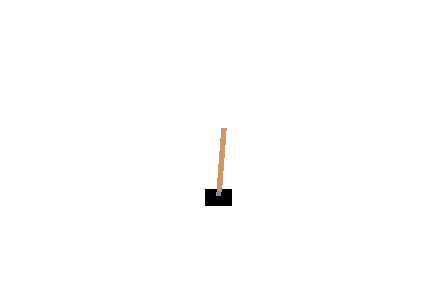
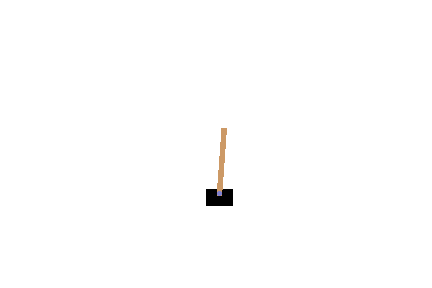
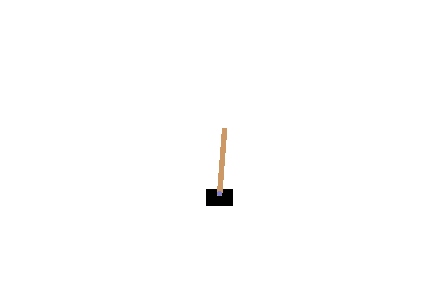
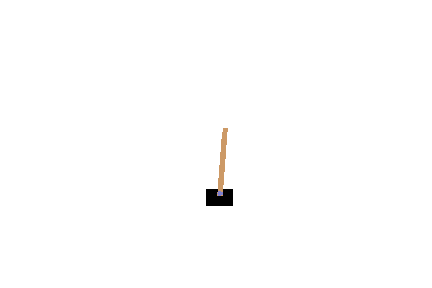
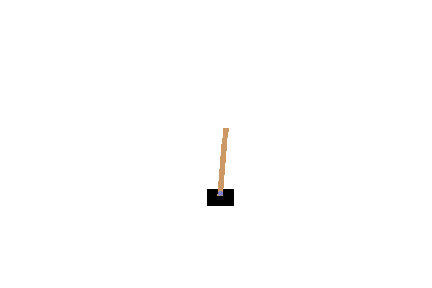
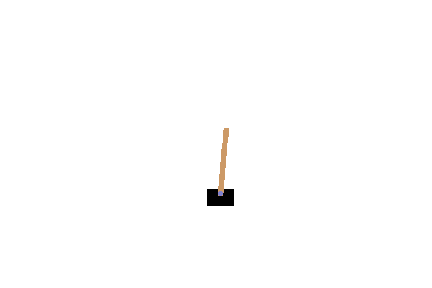
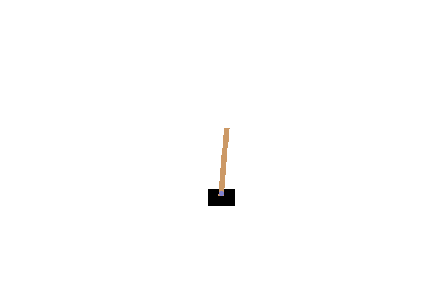
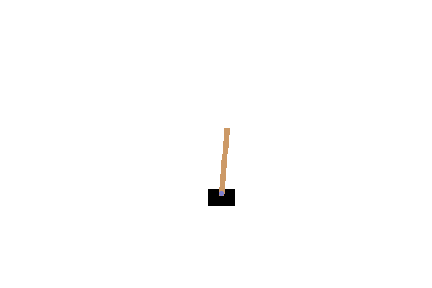
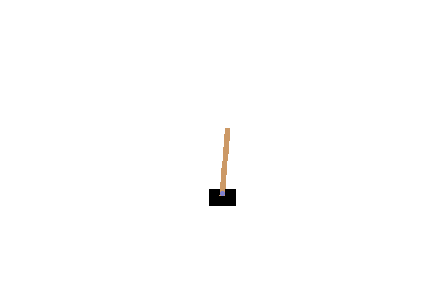
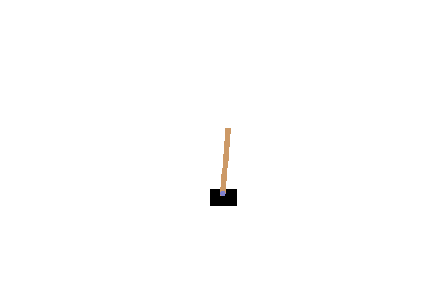
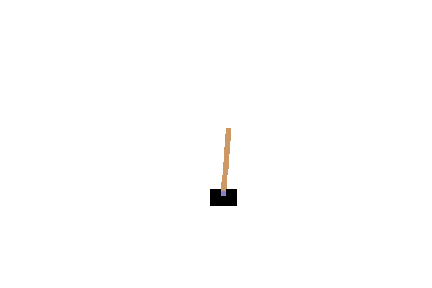
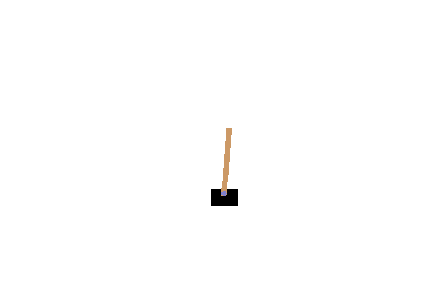
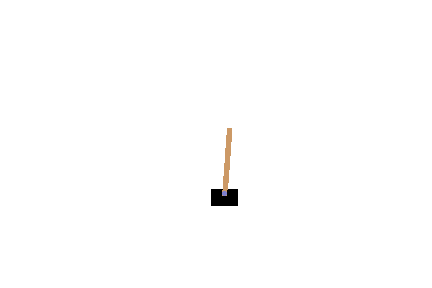
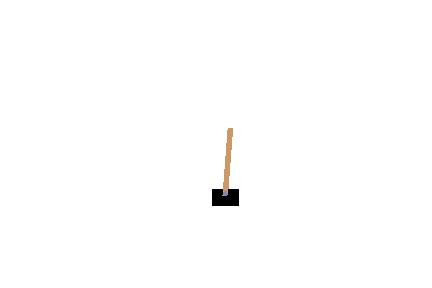
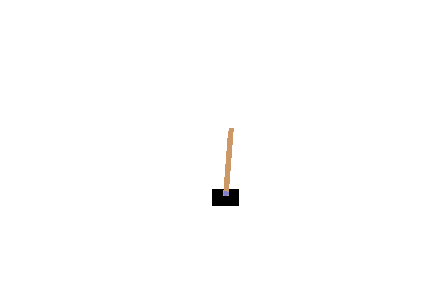
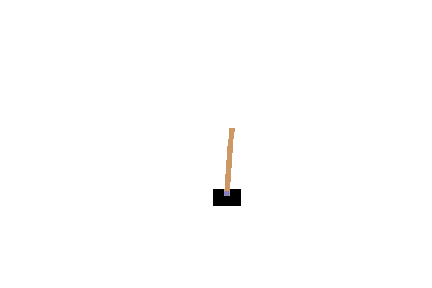
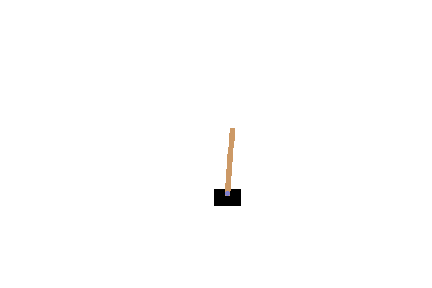
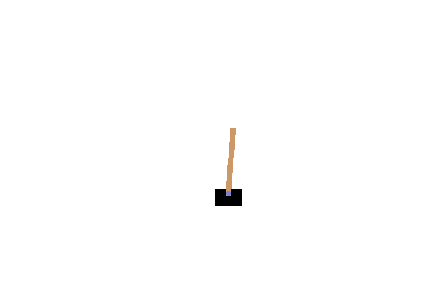
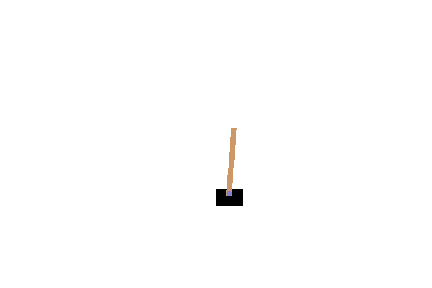
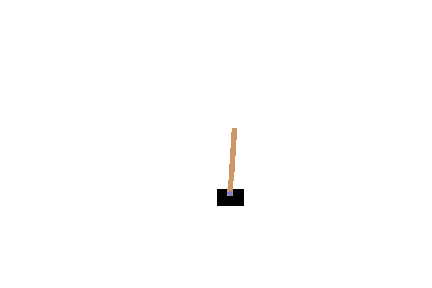
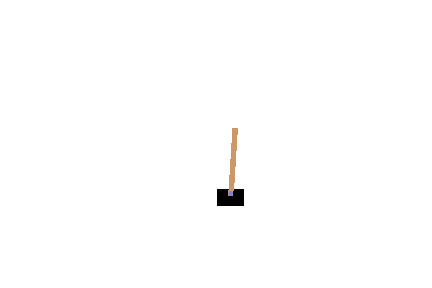
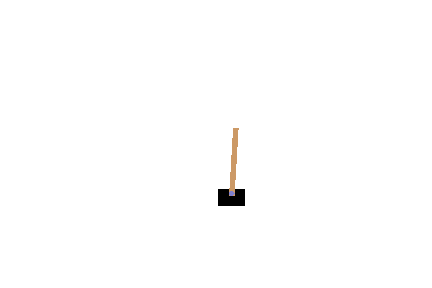
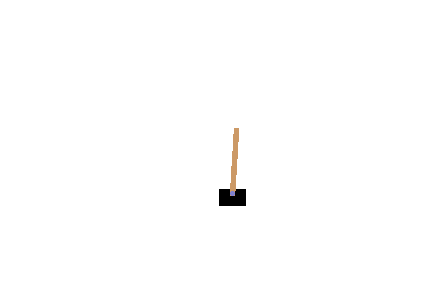
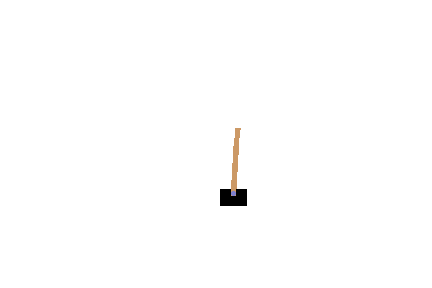
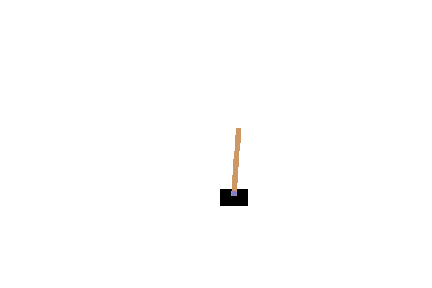
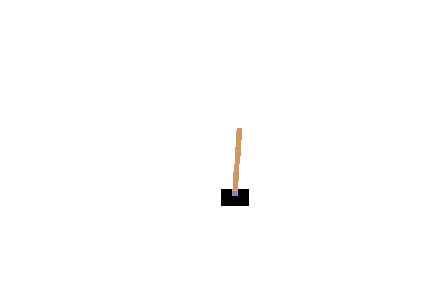
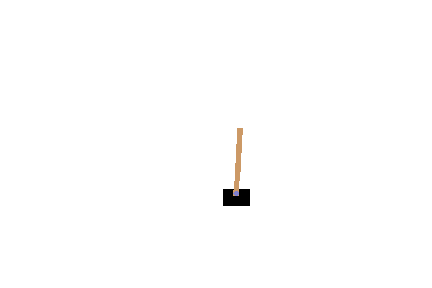
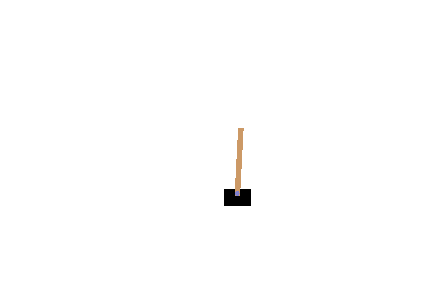
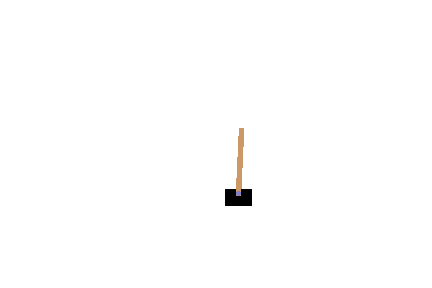
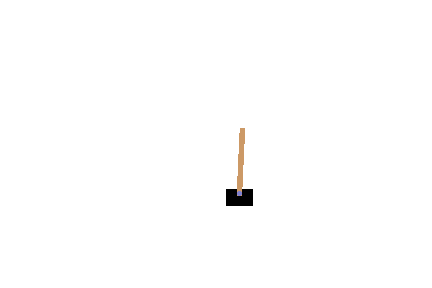
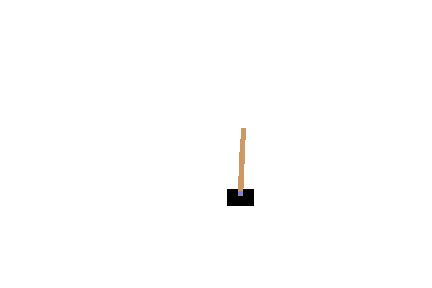
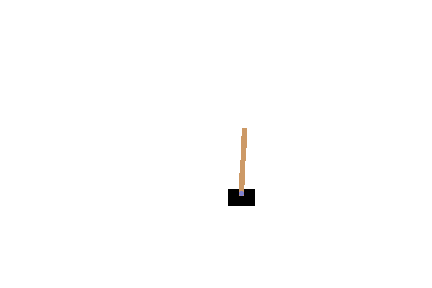
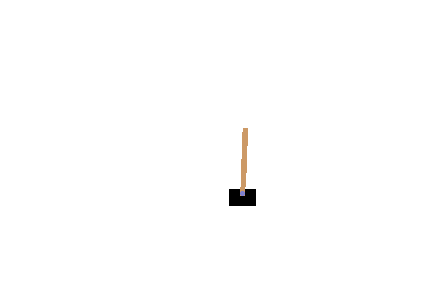
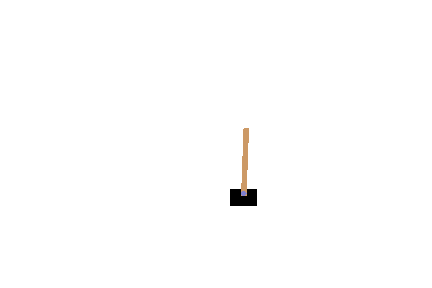
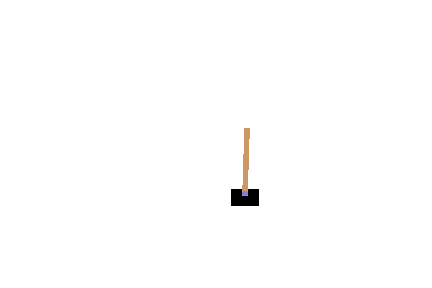
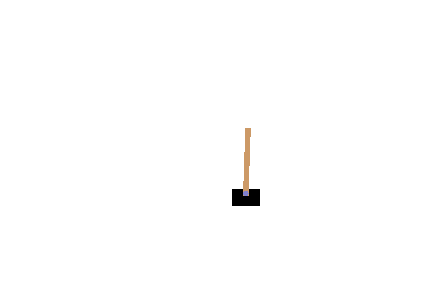
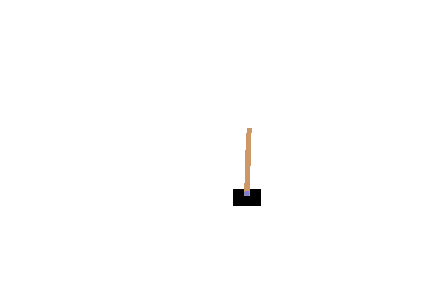
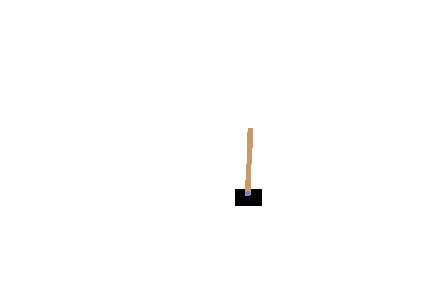
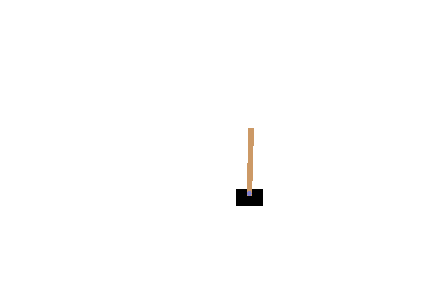
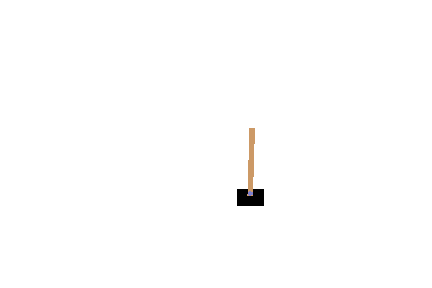
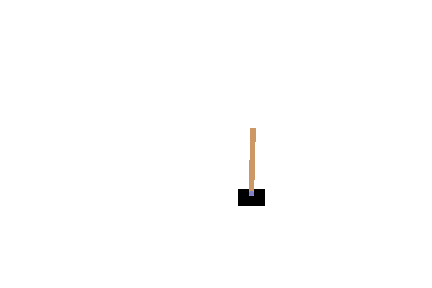
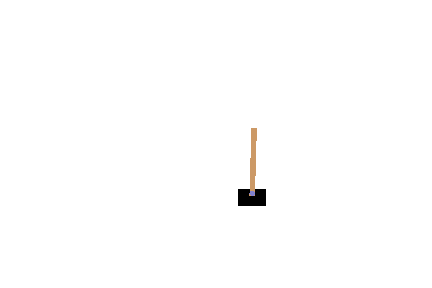
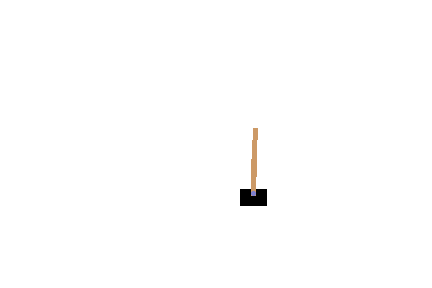
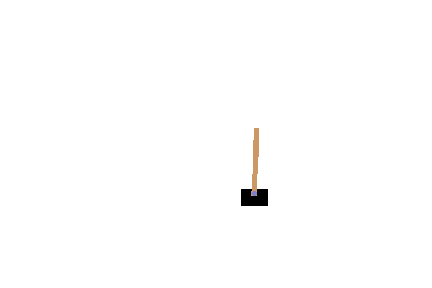
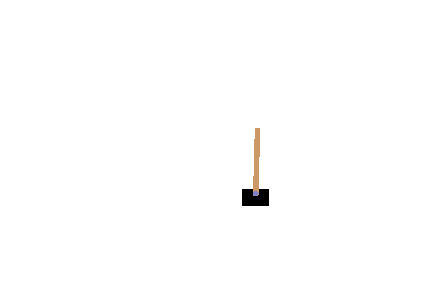
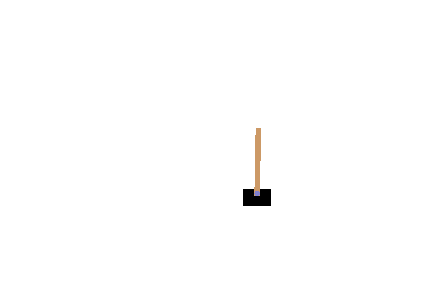
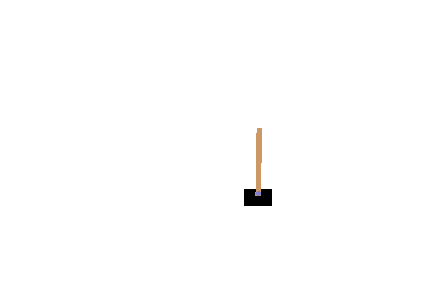
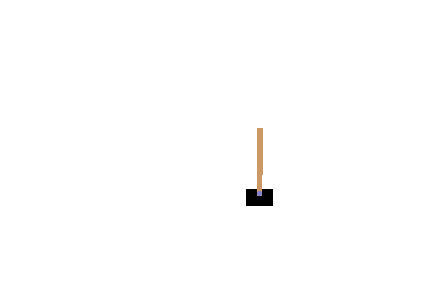
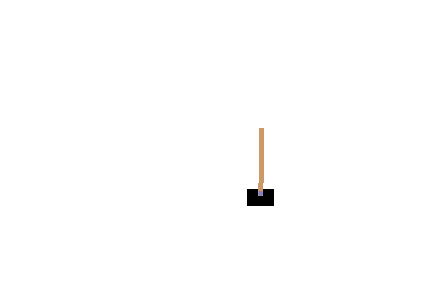
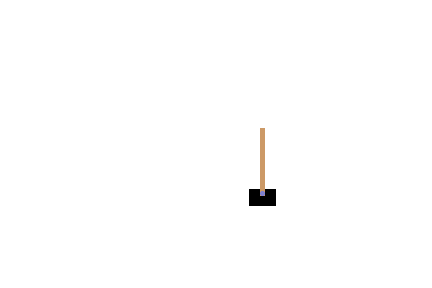
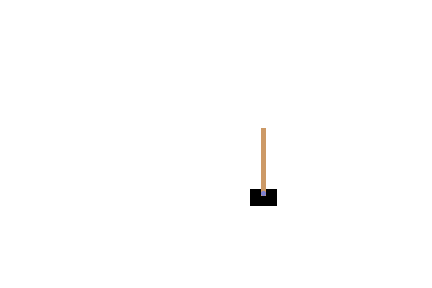
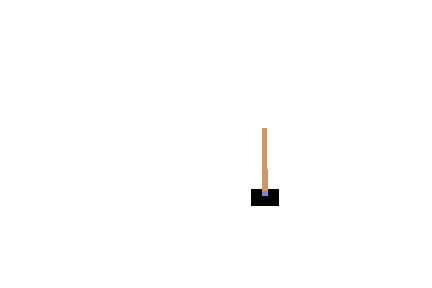
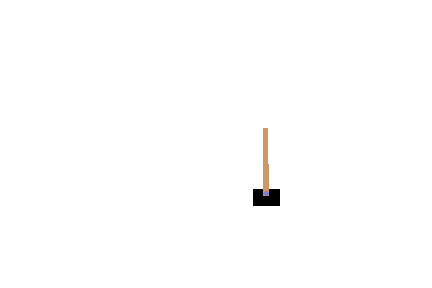
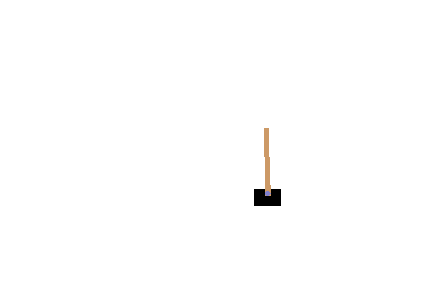
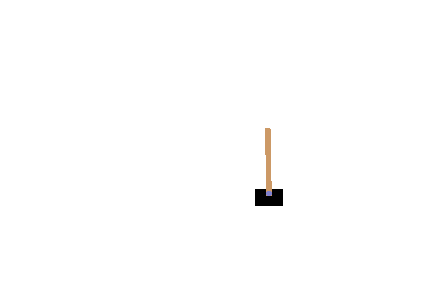
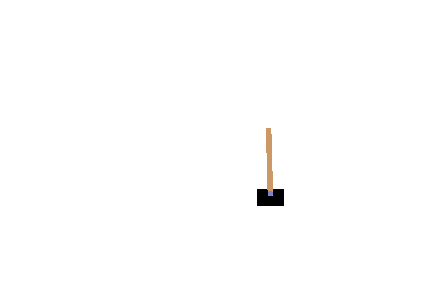
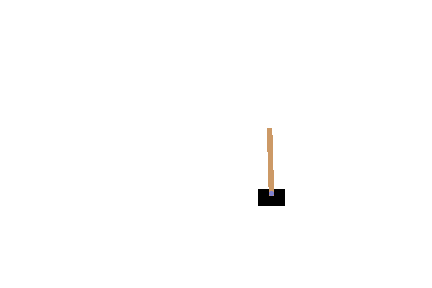
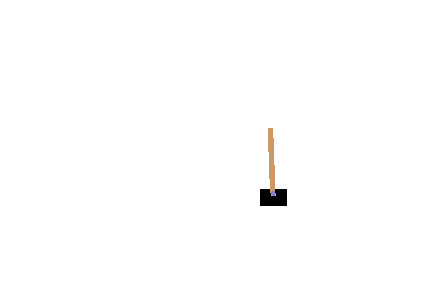
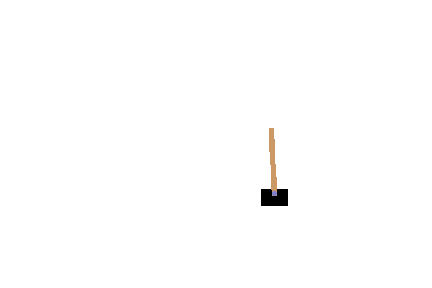
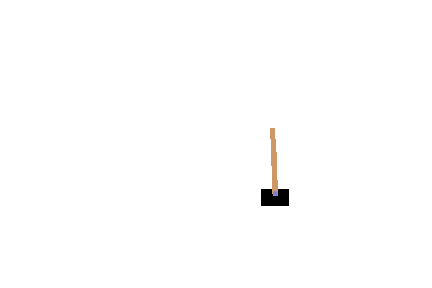
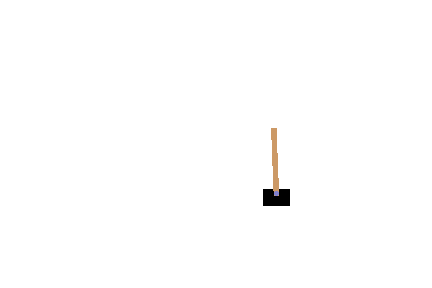
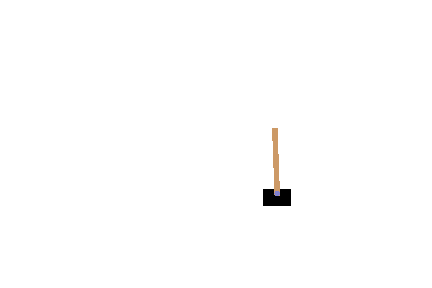
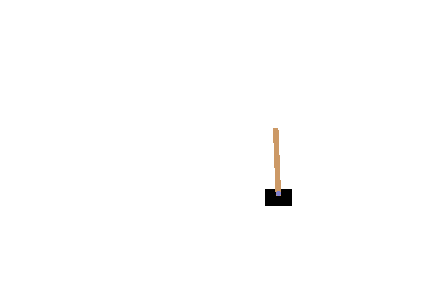
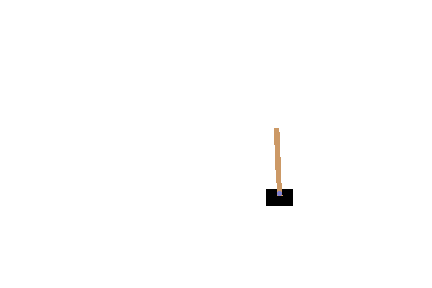
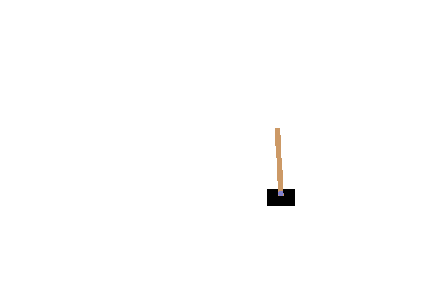
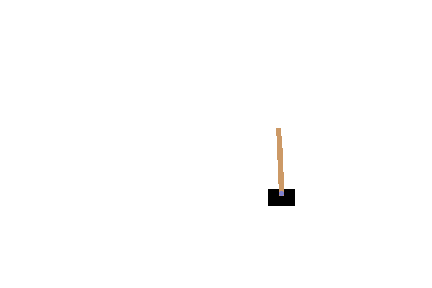
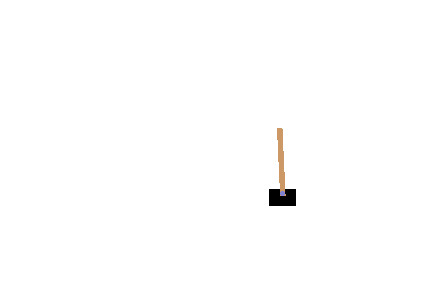
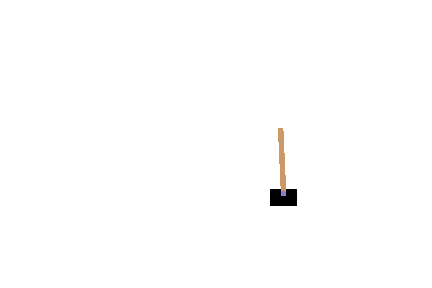
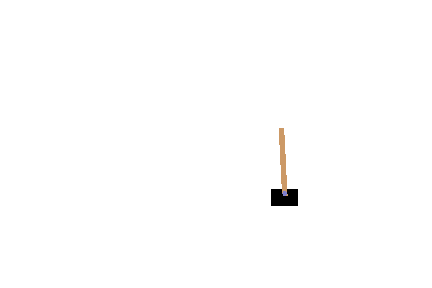
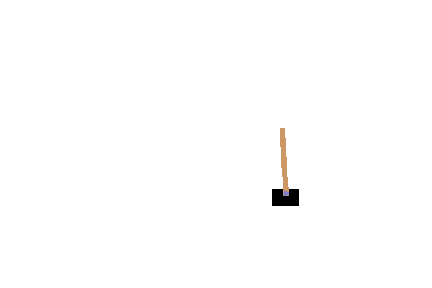
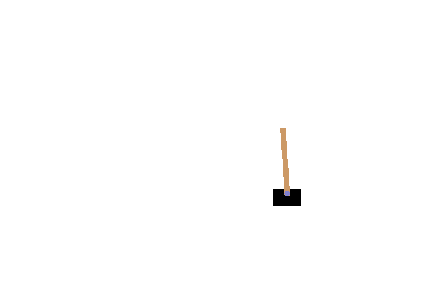
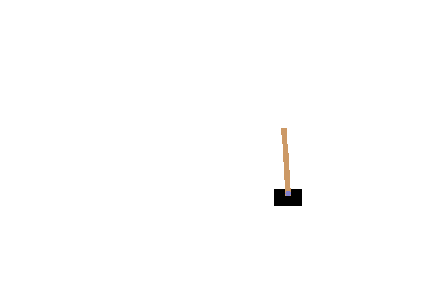
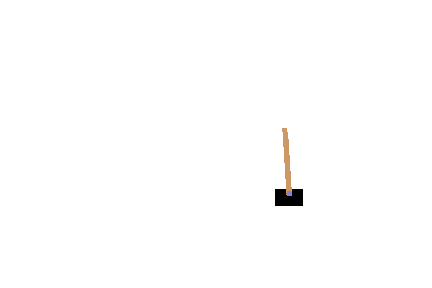
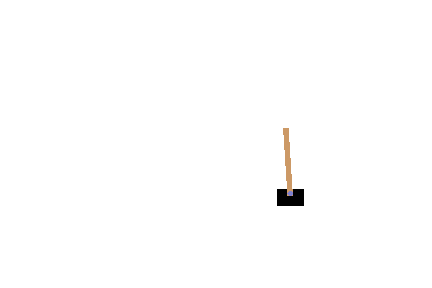
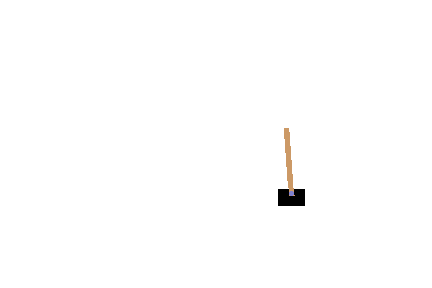
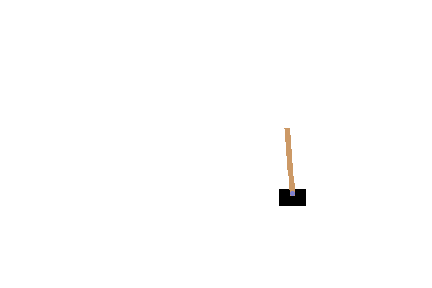
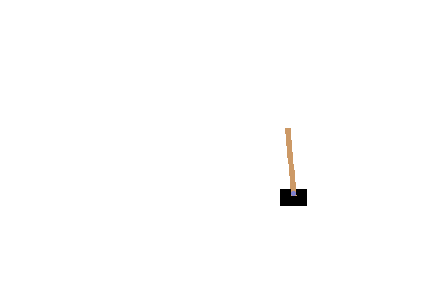
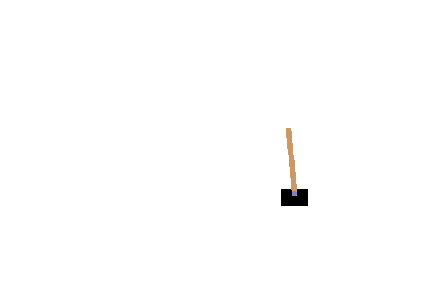
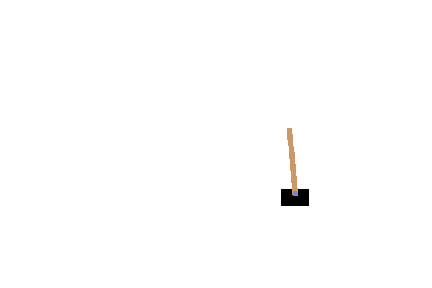
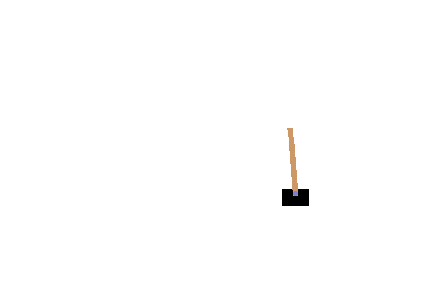
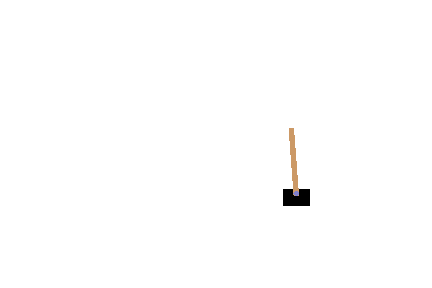
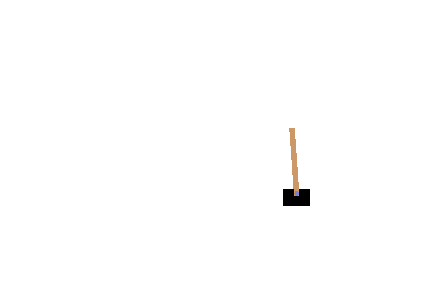
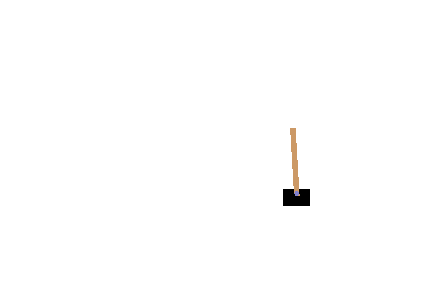
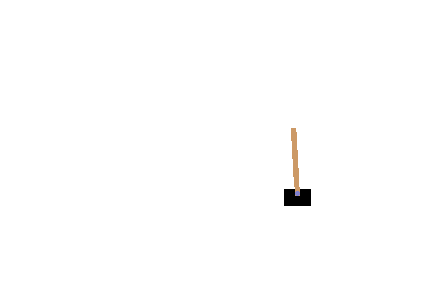
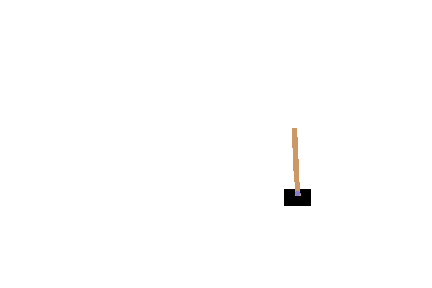
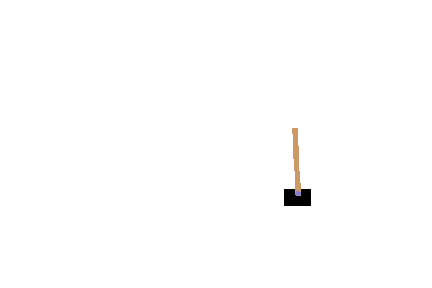
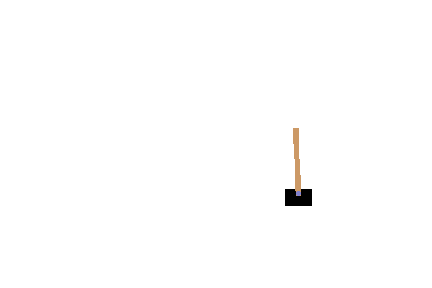
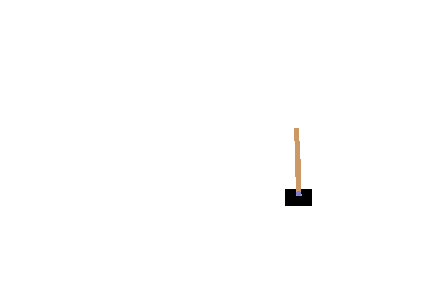
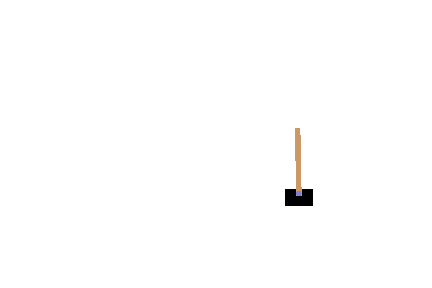
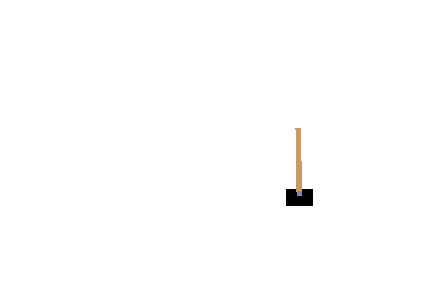
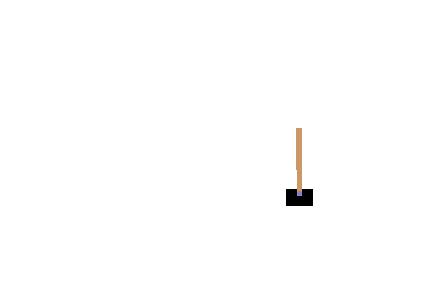
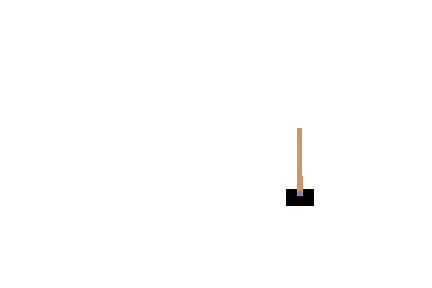
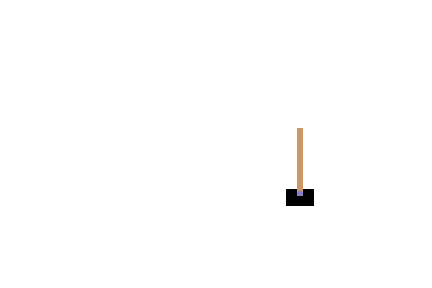
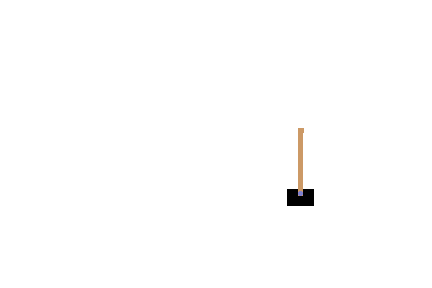
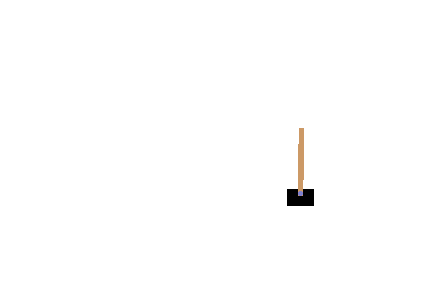
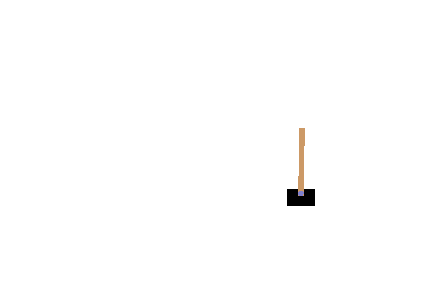
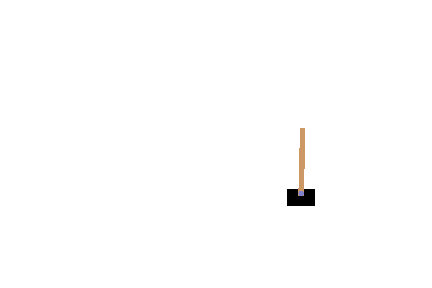
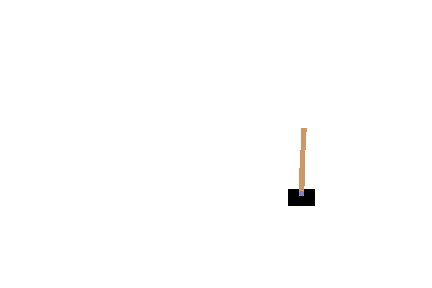
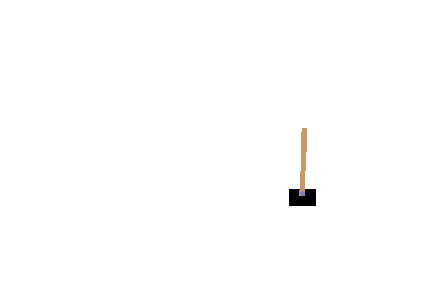
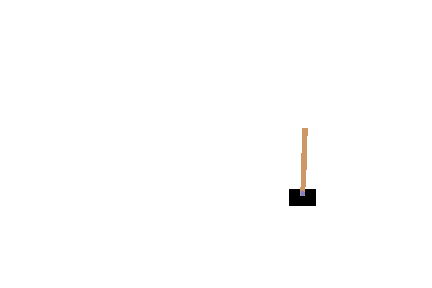
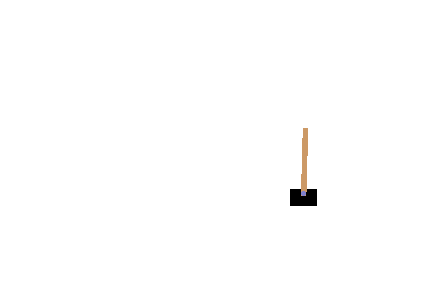
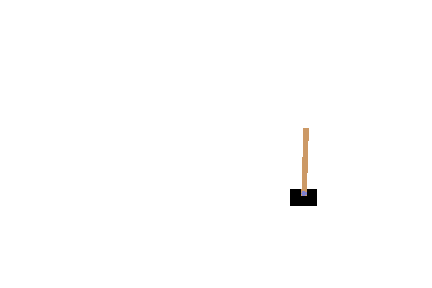
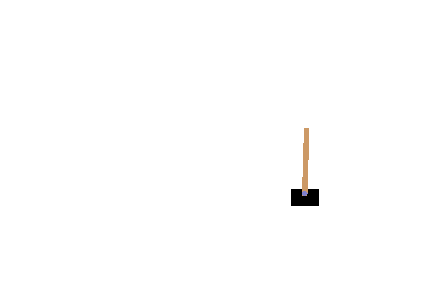
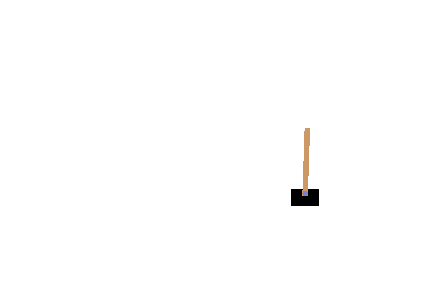
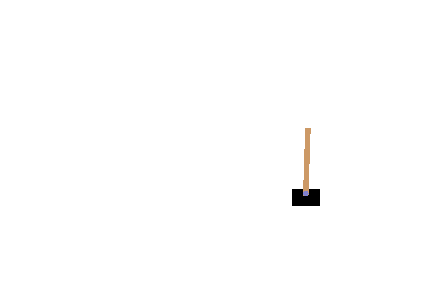
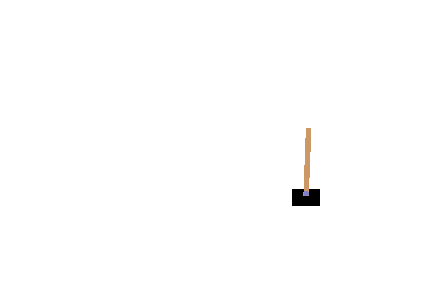
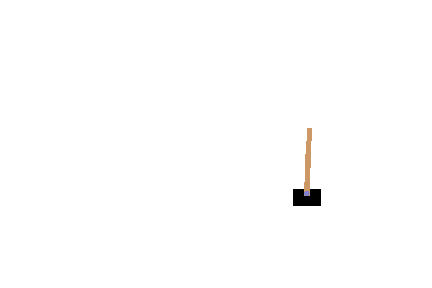
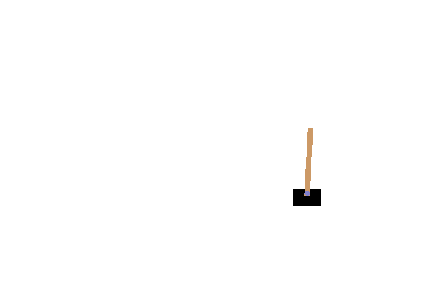
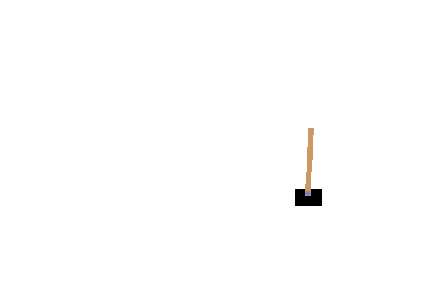
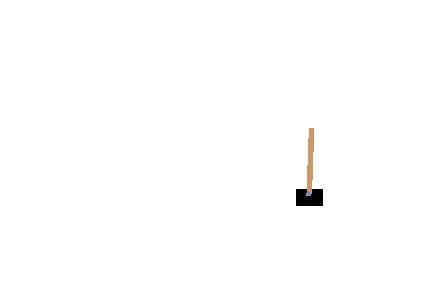
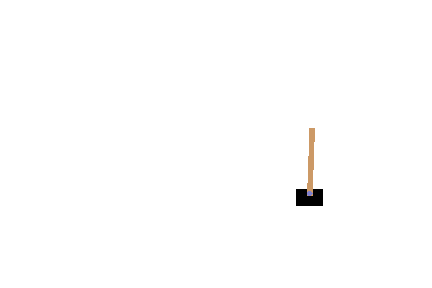
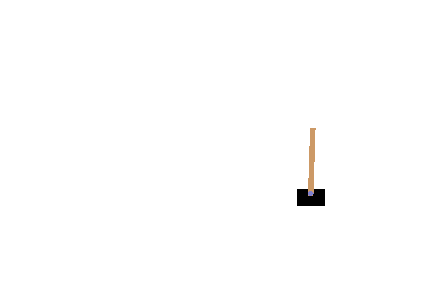
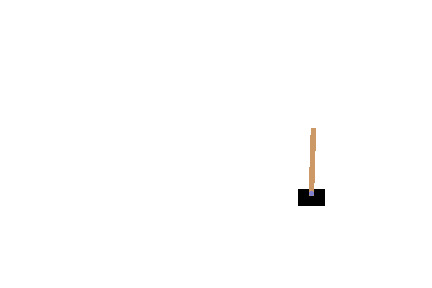
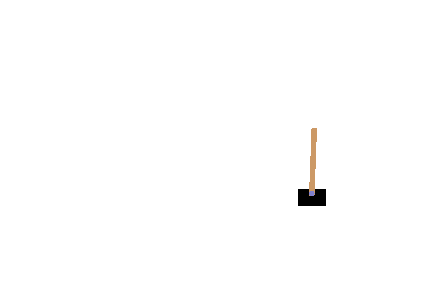
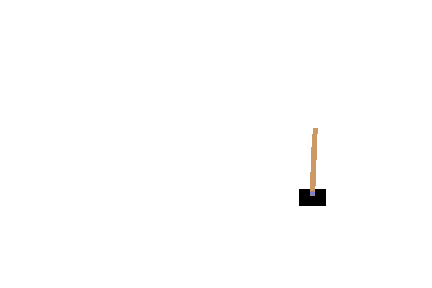
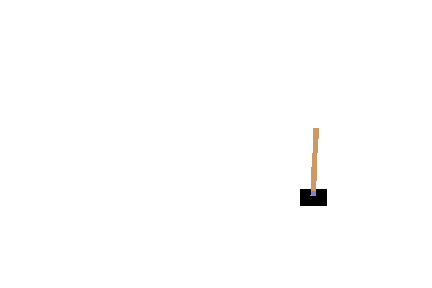
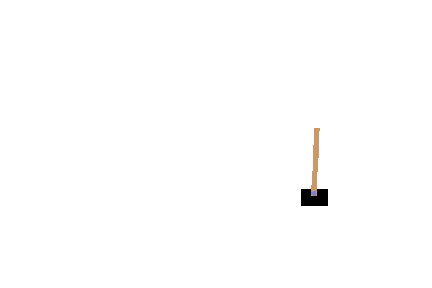
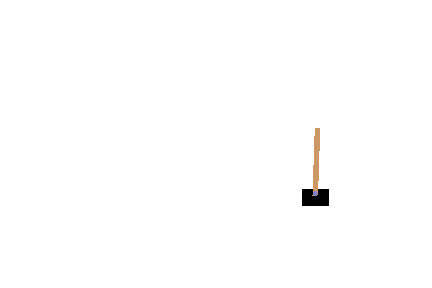
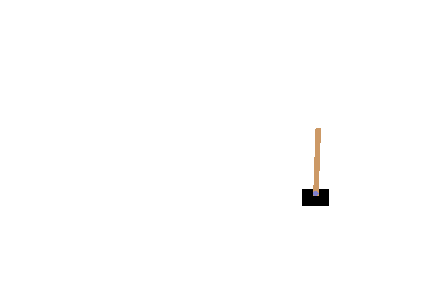
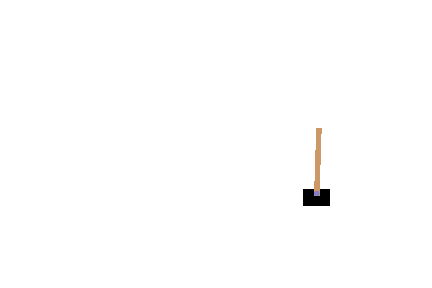
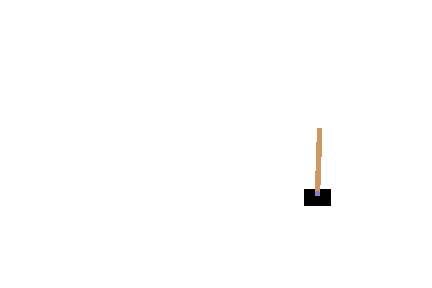
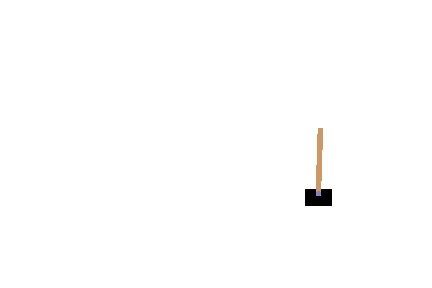
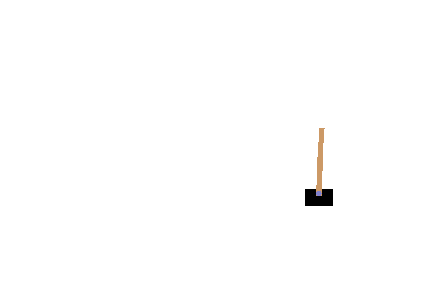
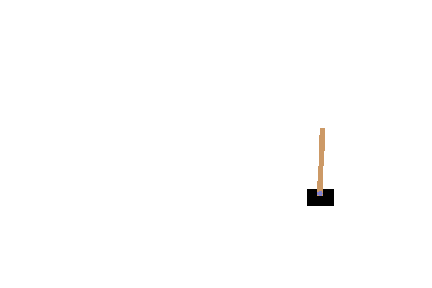
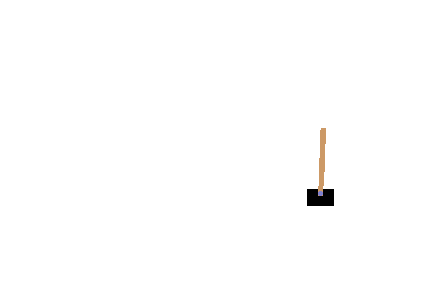
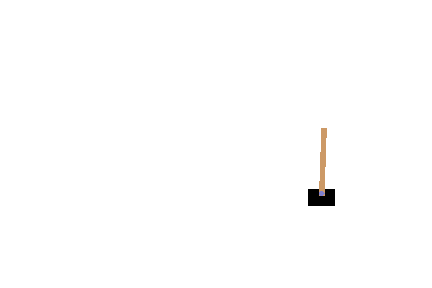
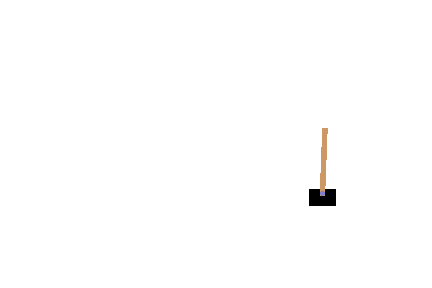
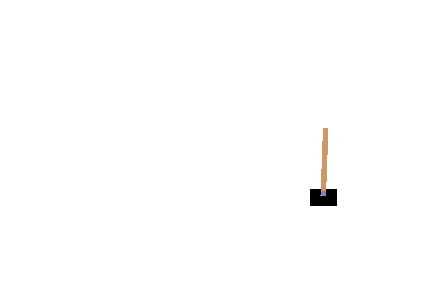
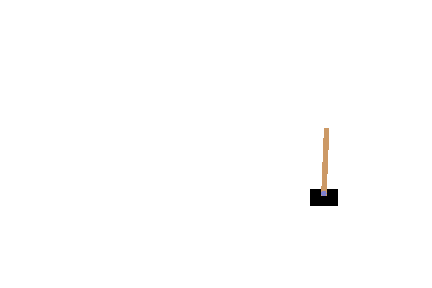
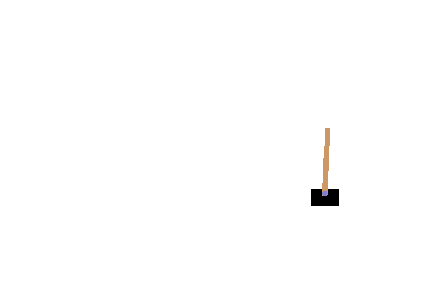
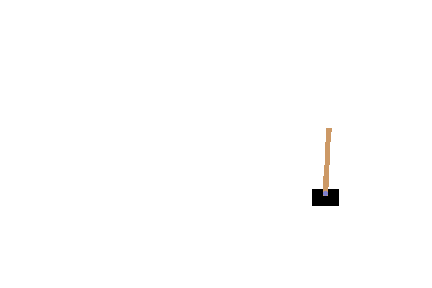
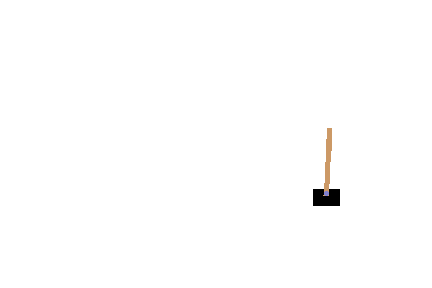
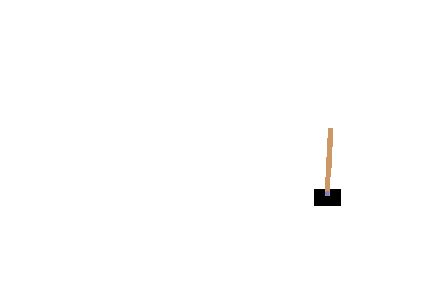
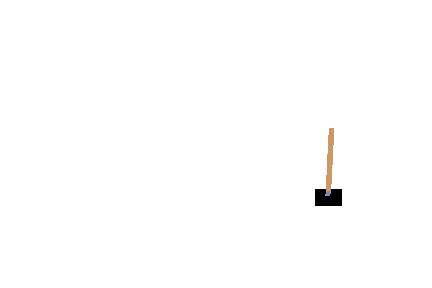
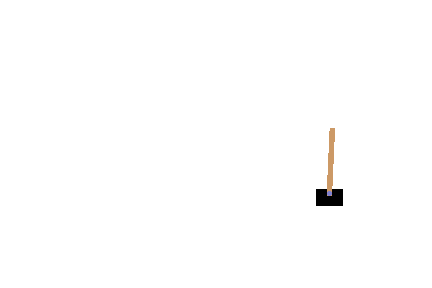
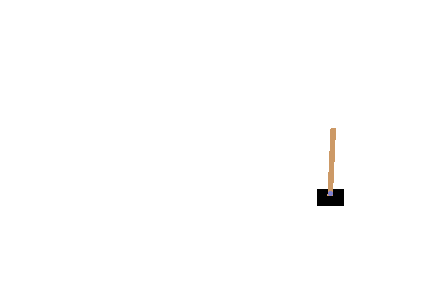
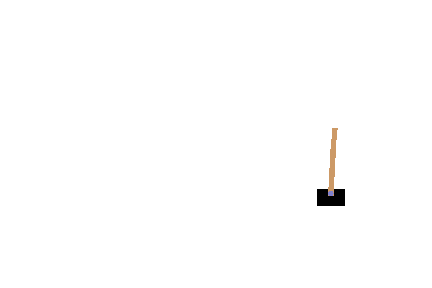
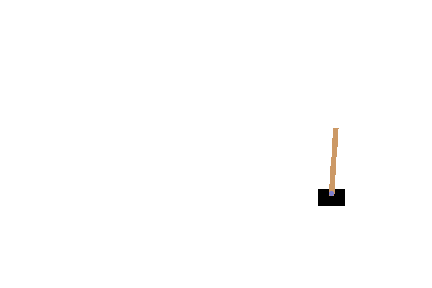
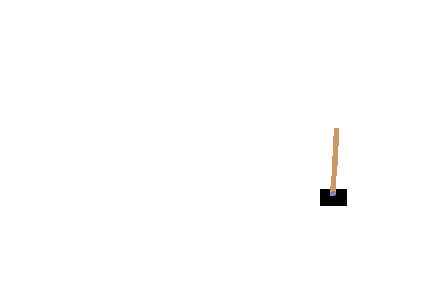
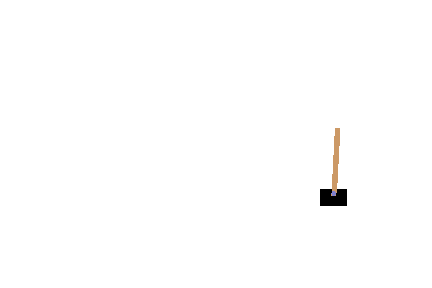
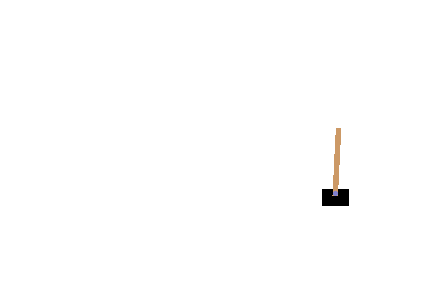
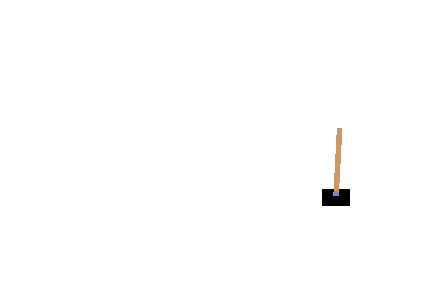
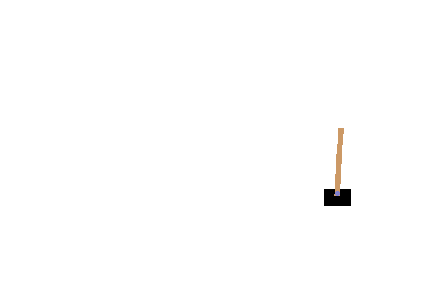
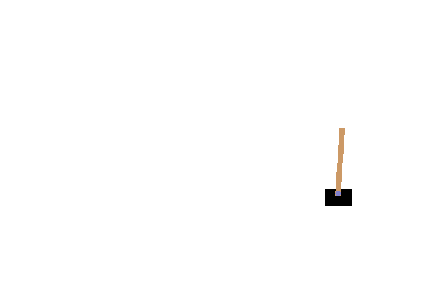
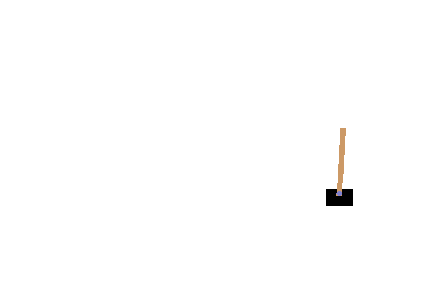
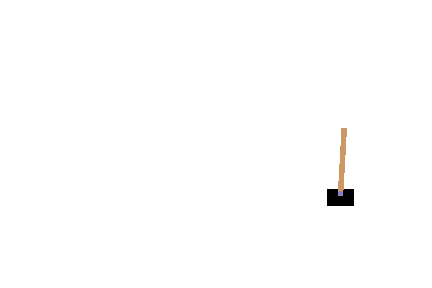
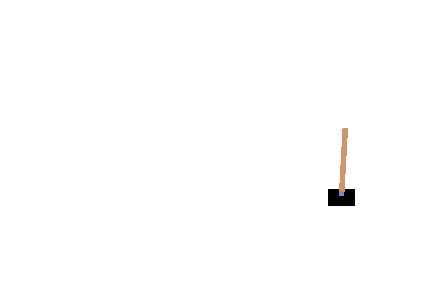
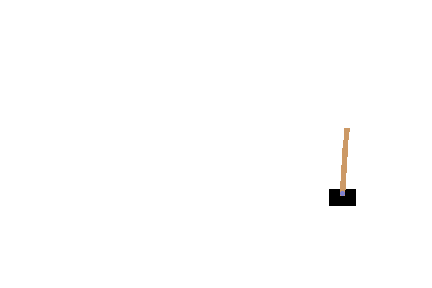
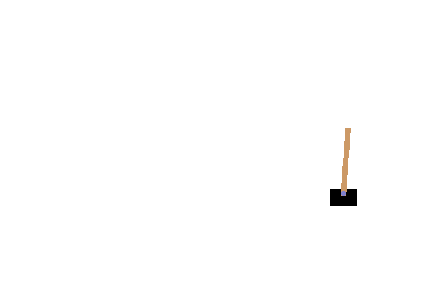
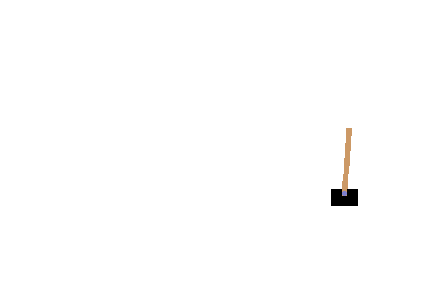
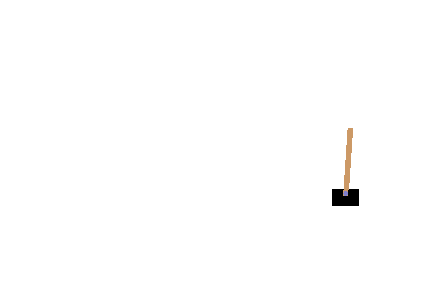
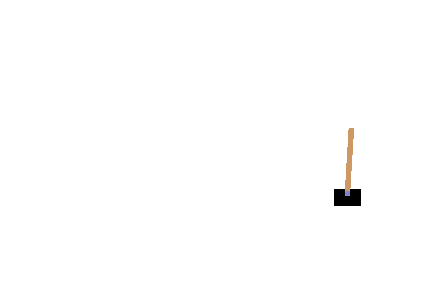
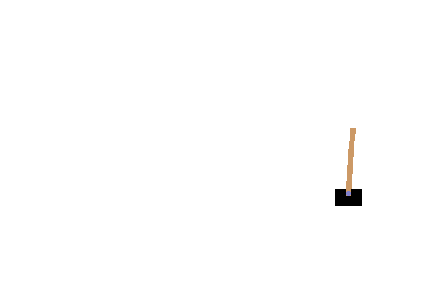
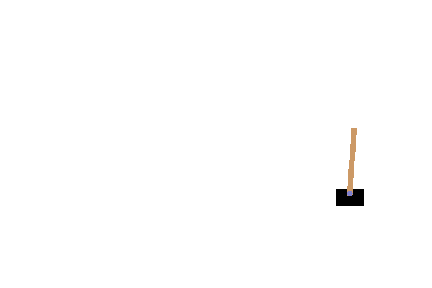
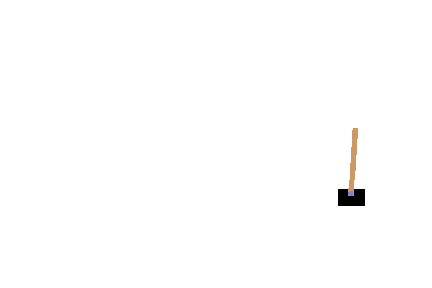
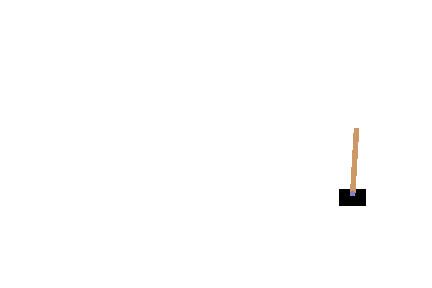
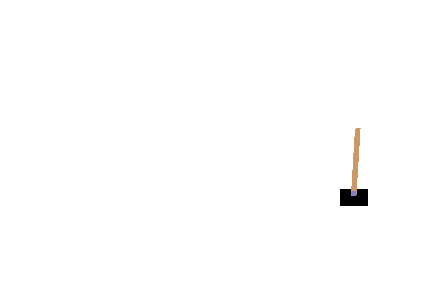
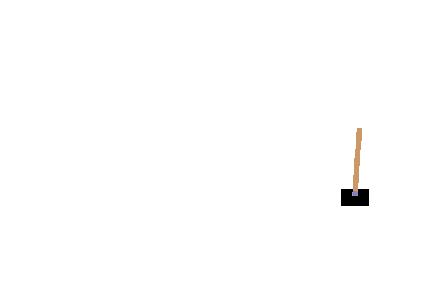
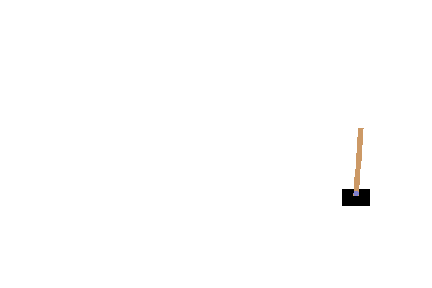
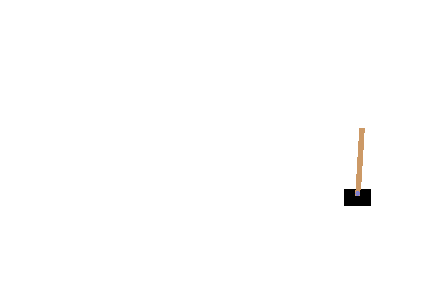
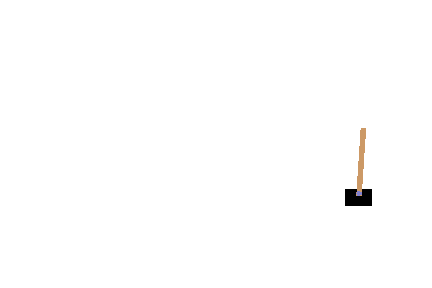
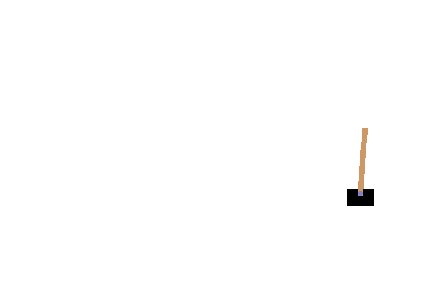
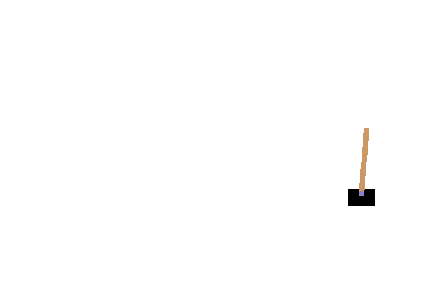
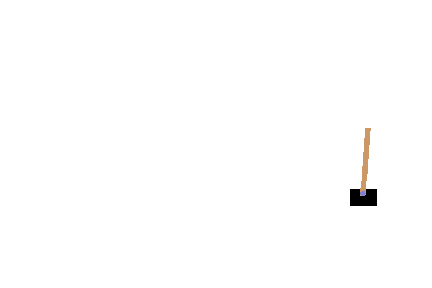
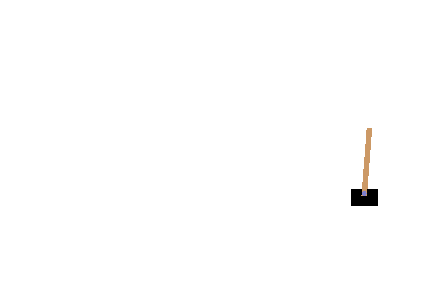
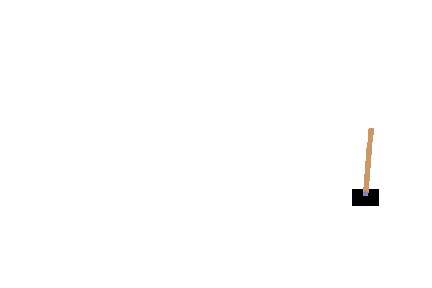
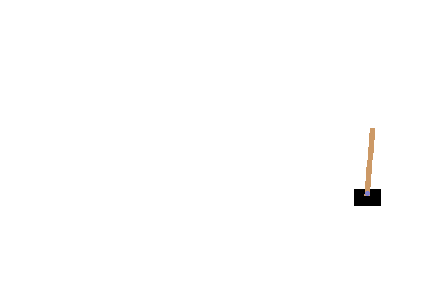
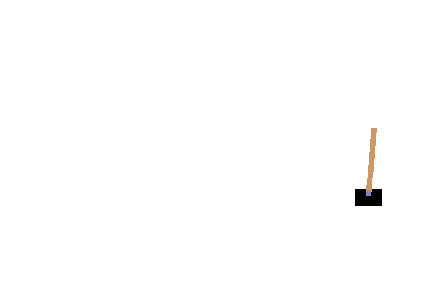
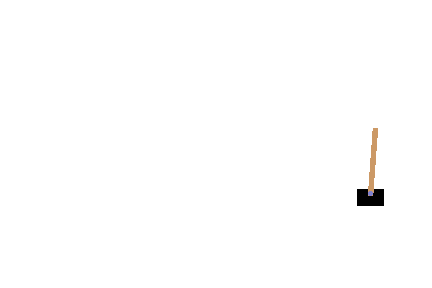
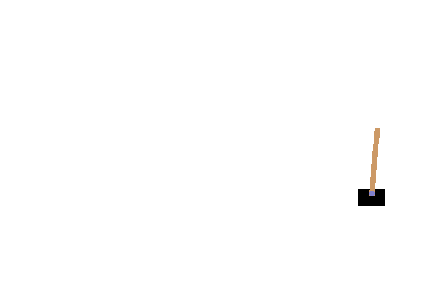
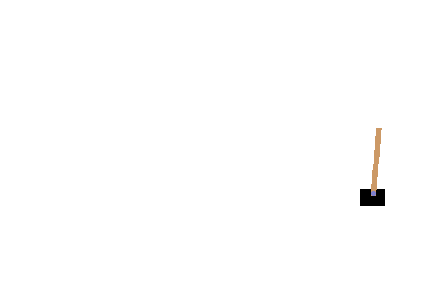
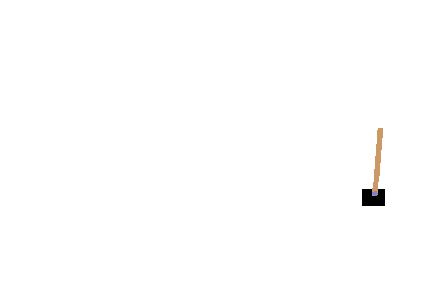
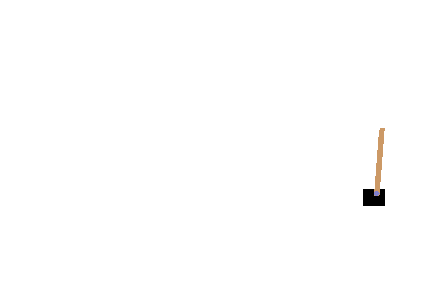
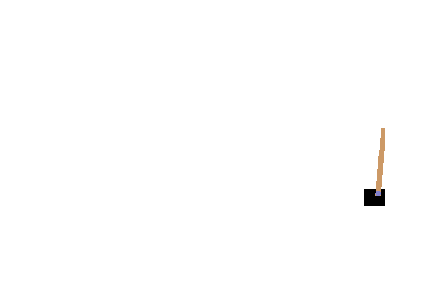
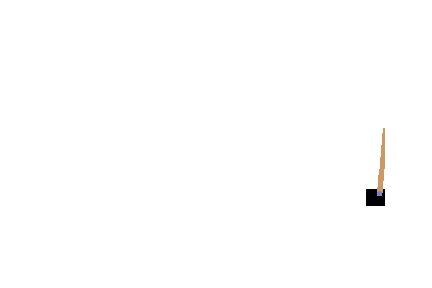
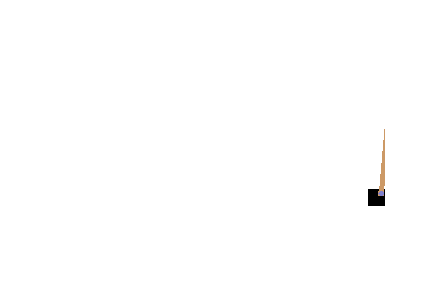
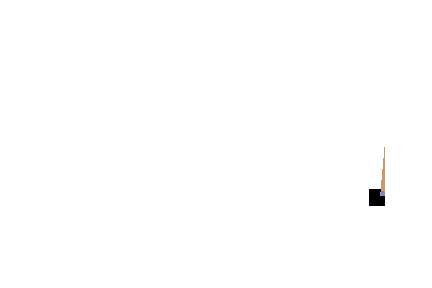
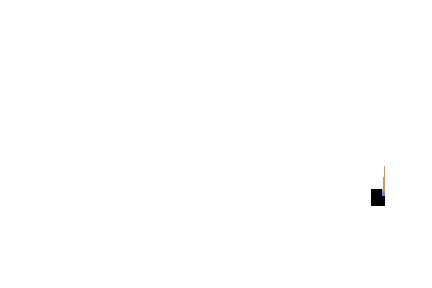
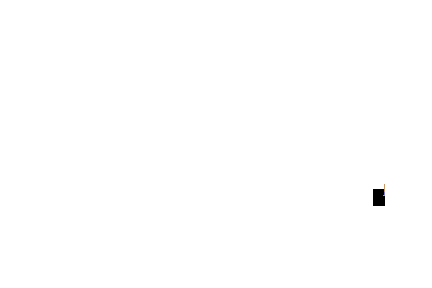

213


In [25]:
# Run a demo of the environment
observation = env.reset()
cum_reward = 0
frames = []
a_t = np.zeros([ACTIONS])
a_t[env.action_space.sample()] = 1
for t in range(5000):
    # Render into buffer.  
    s_t, reward, done, info = env.step(np.argmax(a_t))
    frames.append(env.render(mode = 'rgb_array'))
    readout_t = out.predict(s_t[None, :])
    a_t = np.zeros([ACTIONS])
    a_t[np.argmax(readout_t)] = 1
    
    if done:
        break
env.render(close=True)
display_frames_as_gif(frames)
print(t)